# YOLO_LAB
- 첫번쨰 출력(YOLO_82) 에서 나오는 결과물(bounding box) 확인

In [2]:
import cv2
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt
%matplotlib inline


In [3]:

from matplotlib import pyplot as plt
%matplotlib inline

from bokeh.plotting import figure #pip install bokeh
from bokeh.io import output_notebook, show, push_notebook


output_notebook()


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()
    
    
def create_win(frames, scale=1.0) :    
    global myImage
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    fr=cv2.flip(fr, -1) # because Bokeh flips vertically
    width=fr.shape[1]
    height=fr.shape[0]    

    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=int(width*scale), height=int(height*scale))    
    myImage = p.image_rgba(image=[fr], x=0, y=0, dw=width, dh=height)
    show(p, notebook_handle=True)   
    
    
def update_win(frames) :
    
    all = []
    for f in frames :
        #print(len(f.shape))
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    fr=cv2.flip(fr, 0)
    myImage.data_source.data['image']=[fr]
    push_notebook()

Loading BokehJS ...

##  Yolo 셋팅

In [5]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold, 오브젝트일 확률
nmsThreshold = 0.4   #Non-maximum suppression threshold , 거리가 가까운애들은 하나의 그룹으로 보겟다, 주변보다 상대적으로 값이 높거나 낮거나 하는 애를 뽑겠다.

#YOLO v3는 영상을 무조건 416 사이즈로 변경
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

# Load names of classes
classesFile = "coco.names" 
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg" #네트워크 구조체(CNN 필터 값들)가 포함되어있다, #컨피그 상에서 실제로 Yolo 관련 컨피그가 3개가 있다.
modelWeights = "yolov3.weights"

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


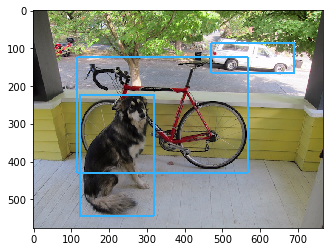

True

In [234]:
cap = cv.VideoCapture('pic/dog2.jpg')

hasFrame, frame = cap.read()

blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], True, crop=False)
#
# 4차원 행렬로 갯수, 채널, 사이즈로 리턴된다

net.setInput(blob) #입력 데이터로 blob를 넣는다

outs = net.forward(getOutputsNames(net)) # 실제 아웃풋은 yolo_82 로만 출력, 해당 레이어의 output 값이 리턴

frameHeight = frame.shape[0]
frameWidth = frame.shape[1]


# Scan through all the bounding boxes output from the network and keep only the
# ones with high confidence scores. Assign the box's class label as the class with the highest score.
classIds = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:] #확률 80개의 값을 가져옴
        classId = np.argmax(scores) #확률에서 높은거 가져옴
        confidence = scores[classId] #확률 값 가져옴
        if confidence > confThreshold: # confThreshold보다 더 높을 경우, 박스를 만듬
            center_x = int(detection[0] * frameWidth)
            center_y = int(detection[1] * frameHeight)
            width = int(detection[2] * frameWidth)
            height = int(detection[3] * frameHeight)
            left = int(center_x - width / 2)
            top = int(center_y - height / 2)
            classIds.append(classId)
            confidences.append(float(confidence))
            boxes.append([left, top, width, height])
            cv2.rectangle(frame, (left, top), (left+width, top+height), (255, 178, 50), 3)
        
imshow("", frame)
cv.imwrite("out2.jpg", frame) 

In [256]:
cells = []
for i in range(len(outs[0])):   
    detection = outs[0][i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.01:        
        cells.append(classId+1)
    else:
        cells.append(0)
    


In [254]:
import math

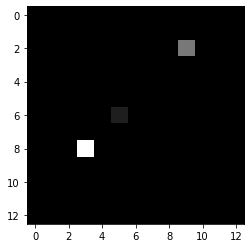

In [295]:
cells = np.array(cells)
s = int(math.sqrt(len(outs[0])/3))
cells = cells.reshape(s,s,3)
img = (cells[:,:,0] + cells[:,:,1] + cells[:,:,2] ) * 0.1
#print(img)
plt.imshow(img, cmap='gray')